# ECE 5554 Computer Vision Final Project

The goal is to correctly classify whether the X-Ray images are Normal or Pneumonia. Computer Vision techniques will be applied and will be trained using Convolutional Neural Networks. The implementation of this project will be provided in this notebook. 

Background Information about the Image Classificaion of X-Rays can be found in the html link provided in the Project Proposal. 

After implementation of the CNN function, the model will be tested for accuracy.This implementation version will involve the use of the PyTorch library.


## 1. Environment Set up. 
Before loading the dataset and images, the environment must be setup for the Google Colab Notebook.

Additional Steps Involved.


a.   Mount Google Drive into Notebook.





In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


a1. Change to the shared ECE5554 Computer Vision Final Project Folder.

In [2]:
# Change to the shared ECE5554 Computer Vision Final Project Folder.
import os
os.chdir('/content/drive/MyDrive/')

b. Import Required Library Modules.

In [3]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from skimage.io import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
import cv2
import matplotlib.pyplot as plt
# PyTorch libraries and modules
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
import random

## 2. Data Processing & Preparation.
This involves processing each file path and load the images for the file paths. The datasets will be loaded from Kaggle. Therefore a kaggle.json file will need to be provided. Each image will be stored in a list based on whether each image is a training, testing, and validation image.



Two functions convert_to_img() and rearrange_dataset() will convert image paths into images and reshuffle the image dataset.

In [4]:
def convert_to_img(path, label):
    '''Take image path, convert to image, and store in list with classification 
    of whether dataset is normal or opaque (pneumonia).
    
    path: Path to image files
    label: 'normal or opaque
    Returns: 
    new_img: list of each image with classification.

    '''

    # Make list of file names.
    filelist = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
    filelist = [i for i in filelist if i is not None]
    
    # Selecting 1/4, 1/2, or all of the images at random.
    #len_half_filelist = len(filelist)//4
    #len_half_filelist = len(filelist)//2
    len_half_filelist = len(filelist)
    half_filelist = []
    count = 0
    while (count < len_half_filelist): 
      half_filelist.append(random.choice(filelist))
      count+=1

    # Label codes 
    label_code = -1 # Default Label Code
    if label == 'normal':
      label_code = 0
    elif label == 'opaque':
      label_code = 1
      

    # Read image files and store each image into list.
    new_img = []
    for file in half_filelist: 
      # reading the image
      image_path = path + "/" +  file
      print("image_path: ", image_path) # Print images being processed.
      img = imread(image_path, as_gray=True)
      if type(img) != None: 
        #img = cv2.resize(img, (28, 28))
        #img = cv2.resize(img, (56, 56))
        img = cv2.resize(img, (80, 80))
        # normalizing the pixel values
        img = img/255.0
        # converting the type of pixel to float 32
        img = img.astype('float32')
        # Append image and label into list.
        new_img.append([img, label_code])
    
    return new_img

In [5]:
def rearrange_dataset(img_dataset):
  ''' Split dataset into images and labels.
  img_dataset: image dataset with images and labels combined.
  Returns: 
  dataset_x: array of images
  dataset_y: array of labels
  '''
  random.shuffle(img_dataset)
  dataset_x = [img_dataset[i][0] for i in range(len(img_dataset))]
  dataset_y = [img_dataset[i][1] for i in range(len(img_dataset))]
  dataset_x = np.array(dataset_x)
  dataset_y = np.array(dataset_y)
  dataset_x.shape
  return dataset_x, dataset_y

Preprocessing image dataset will start here. Note Kaggle dataset will be used. 

Streaming output truncated to the last 5000 lines.
image_path:  content/drive/My Drive/train/normal/IM-0411-0001.jpeg
image_path:  content/drive/My Drive/train/normal/IM-0523-0001-0002.jpeg
image_path:  content/drive/My Drive/train/normal/NORMAL2-IM-0673-0001.jpeg
image_path:  content/drive/My Drive/train/normal/NORMAL2-IM-0618-0001.jpeg
image_path:  content/drive/My Drive/train/normal/IM-0710-0001.jpeg
image_path:  content/drive/My Drive/train/normal/IM-0629-0001-0002.jpeg
image_path:  content/drive/My Drive/train/normal/NORMAL2-IM-0439-0001.jpeg
image_path:  content/drive/My Drive/train/normal/NORMAL2-IM-1043-0001.jpeg
image_path:  content/drive/My Drive/train/normal/IM-0665-0001.jpeg
image_path:  content/drive/My Drive/train/normal/NORMAL2-IM-0947-0001.jpeg
image_path:  content/drive/My Drive/train/normal/IM-0177-0001.jpeg
image_path:  content/drive/My Drive/train/normal/NORMAL2-IM-0929-0001.jpeg
image_path:  content/drive/My Drive/train/normal/IM-0269-0001.jpeg
image_path:  content

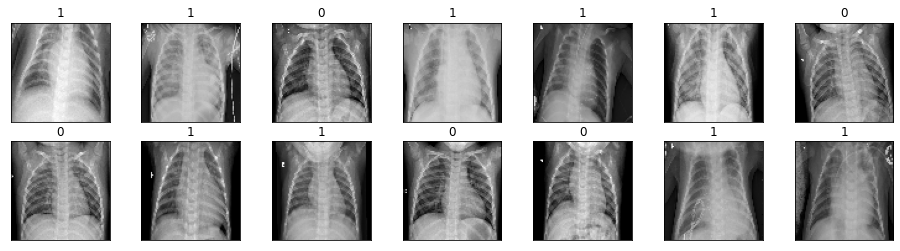

In [6]:
# Uncomment this section only if .json file is not provided or hasn't been utilized.
'''! pip install -q kaggle
#from google.colab import files
#files.upload()
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets download -d pcbreviglieri/pneumonia-xray-images

#import zipfile

#zf = "pneumonia-xray-images.zip"
#target_dir = "content/drive/My Drive"
#zfile = zipfile.ZipFile(zf)
#zfile.extractall(target_dir)

#print("uploaded_data: ", uploaded_data)
#print(type(uploaded_data))
#print(uploaded_data.keys())
#print(uploaded_data.values())
'''

# Preprocessing Training, Validation, and Testing datasets.
train_normal_path = 'content/drive/My Drive/train/normal'
train_dataset_normal = convert_to_img(train_normal_path, "normal")
train_opaque_path = 'content/drive/My Drive/train/opacity'
train_dataset_opaque = convert_to_img(train_opaque_path, "opaque")
train_dataset = train_dataset_normal + train_dataset_opaque
train_x, train_y = rearrange_dataset(train_dataset)

val_normal_path = 'content/drive/My Drive/val/normal'
val_dataset_normal = convert_to_img(val_normal_path, 'normal')
val_opaque_path = 'content/drive/My Drive/val/opacity'
val_dataset_opaque = convert_to_img(val_opaque_path, 'opaque')
val_dataset = val_dataset_normal + val_dataset_opaque
val_x, val_y = rearrange_dataset(val_dataset)

# Visualizing X-Rays using randomly selected images.
fig, axes = plt.subplots(ncols=7, nrows=2, figsize=(16, 4))

indices = np.random.choice(len(train_x), 14)
counter = 0

for i in range(2):
    for j in range(7):
        axes[i,j].set_title(train_y[indices[counter]])
        axes[i,j].imshow(train_x[indices[counter]], cmap='gray')
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1
plt.show()

## 3. Create CNN function.

After taking all files in path and converting to list of images and labels classifying each image using 0's and 1's (Normal and Pneumonia respectively), the CNN model is created. Note that this CNN model is implemented from the PyTorch library. Most of the concepts taught in the course such as cross-correlation and convolution are built into the PyTorch library. Most of the derivations of the CNN implementation are inspired by [1]. Additional steps are shown below.

[1] https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/

a. Convert Train Images into Torch Format. This will be used when training the CNN model.

In [7]:
# converting training images into torch format
print("Length of train_x: ", len(train_x))
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)
print("train_x.shape: ", train_x.shape)
train_x = train_x.reshape(train_x.shape[0], 1, train_x.shape[1], train_x.shape[2])
print("train_x.shape[0]: ",train_x.shape[0])
print("train_x.shape[1]: ",train_x.shape[1])
print("train_x.shape[2]: ",train_x.shape[2])
train_x = torch.from_numpy(train_x)

# converting the target into torch format
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape
print("train_x.shape: ", train_x.shape)
print("train_y.shape: ", train_y.shape)

# converting validation images into torch format
val_x = val_x.reshape(val_x.shape[0], 1, val_x.shape[1], val_x.shape[2])
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_y.astype(int);
val_y = torch.from_numpy(val_y)

# shape of validation data
val_x.shape, val_y.shape
print("val_x.shape: ", val_x.shape)
print("val_y.shape: ", val_x.shape)

Length of train_x:  4192
train_x.shape:  (4192, 80, 80)
train_x.shape[0]:  4192
train_x.shape[1]:  1
train_x.shape[2]:  80
train_x.shape:  torch.Size([4192, 1, 80, 80])
train_y.shape:  torch.Size([4192])
val_x.shape:  torch.Size([1040, 1, 80, 80])
val_y.shape:  torch.Size([1040, 1, 80, 80])


b. Implement the Device Congifuration and Hyperparameters.

Note: Given that PyTorch will be implemented on Google Colab, there will not be additional memory available. For the following purposes, device will be a CPU. 
The Hyper parameters are initialized for use in the PyTorch implementation of the CNN model.

In [8]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 12
num_classes = 2
batch_size = 4
learning_rate = 0.001

c. Create CNN class using PyTorch using the hyperparamters above and return the model for display purposes. This will give a clear overview of the model used. 

In [9]:
# Creating a CNN class
class ConvNet(nn.Module):
	#  Determine what layers and their order in CNN object 
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layer1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3)
        self.bn1 = BatchNorm2d(batch_size)
        self.max_pool1 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu1 = nn.ReLU()

        self.conv_layer2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3)
        self.bn2 = BatchNorm2d(2*batch_size)
        self.max_pool2 = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.relu2 = nn.ReLU()
        BatchNorm2d(batch_size)
    
    # Progresses data across layers    
    def forward(self, x):
        out = self.conv_layer1(x)
        out = self.bn1(out)
        out = self.max_pool1(out)
        out = self.relu1(out)
        out = self.conv_layer2(out)
        out = self.bn2(out)
        out = self.max_pool2(out)
        out = self.relu2(out)
        out = out.reshape(out.size(0), -1)
        return out

In [10]:
# defining the model
model = ConvNet()
# defining the optimizer
optimizer = Adam(model.parameters(), lr=learning_rate)
print("optimizer: ", optimizer)
# defining the loss function
criterion = CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

print("model: ", model)
train_losses = []
val_losses = []


optimizer:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
model:  ConvNet(
  (conv_layer1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu1): ReLU()
  (conv_layer2): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu2): ReLU()
)


## 5. Training.

After implementing the CNN model, the model is trained using the training function below. This will create the CNN model class from above and train the model using a certain number of epochs. While train with a certain number of epochs, the amount of loss values will be obtained using each epoch.

a) Train each epoch and obtain loss values.

In [11]:
def train(epoch):
    model.train()
    tr_loss = 0
    # getting the training set
    x_train, y_train = Variable(train_x), Variable(train_y)
    # getting the validation set
    x_val, y_val = Variable(val_x), Variable(val_y)
    # converting the data into GPU format
    if torch.cuda.is_available():
        x_train = x_train.cuda()
        y_train = y_train.cuda()
        x_val = x_val.cuda()
        y_val = y_val.cuda()


    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    
    # prediction for training and validation set
    # print("x_train: ", x_train)
    output_train = model(x_train)
    output_val = model(x_val)

    # computing the training and validation loss
    loss_train = criterion(output_train, y_train.long())
    loss_val = criterion(output_val, y_val.long())
    train_losses.append(loss_train)
    val_losses.append(loss_val)

    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    tr_loss = loss_train.item()
    print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    return output_train, output_val, loss_val

    # printing the validation loss
    if epoch%2 == 0:
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_val)
    
# training the model
output_train_models = []; output_val_models = []; loss_values = [];
for epoch in range(num_epochs):
    # print(epoch)
    # Given that a GPU would be required to train the model and time constraints, 
    # the model will be trained for each epoch. After finishing, the epoch with 
    # the highest loss value (loss_val) will be used for evaluation of the model.
    output_train_epoch, output_val_epoch, loss_val = train(epoch)
    output_train_models.append(output_train_epoch)
    output_val_models.append(output_val_epoch)
    loss_values.append(loss_val.item())

#print("output_train_models: ", output_train_models)
#print("output_val_models: ", output_val_models)
#print("loss_values: ", loss_values)
# Take output_train_model with highest loss value from loss_values list.
highest_val_loss = max(loss_values)
high_i = loss_values.index(highest_val_loss)
  


Epoch :  1 	 loss : tensor(7.8245, grad_fn=<NllLossBackward0>)
Epoch :  2 	 loss : tensor(7.7927, grad_fn=<NllLossBackward0>)
Epoch :  3 	 loss : tensor(7.7645, grad_fn=<NllLossBackward0>)
Epoch :  4 	 loss : tensor(7.7384, grad_fn=<NllLossBackward0>)
Epoch :  5 	 loss : tensor(7.7143, grad_fn=<NllLossBackward0>)
Epoch :  6 	 loss : tensor(7.6921, grad_fn=<NllLossBackward0>)
Epoch :  7 	 loss : tensor(7.6715, grad_fn=<NllLossBackward0>)
Epoch :  8 	 loss : tensor(7.6524, grad_fn=<NllLossBackward0>)
Epoch :  9 	 loss : tensor(7.6341, grad_fn=<NllLossBackward0>)
Epoch :  10 	 loss : tensor(7.6165, grad_fn=<NllLossBackward0>)
Epoch :  11 	 loss : tensor(7.5996, grad_fn=<NllLossBackward0>)
Epoch :  12 	 loss : tensor(7.5833, grad_fn=<NllLossBackward0>)


b) Plot amount of losses for each epoch.

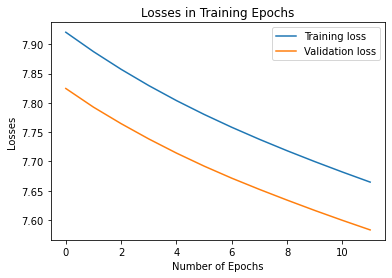

In [12]:
def detach(tensorlist):
    detached_list = []
    for i in range(len(tensorlist)):
        # print("tensorlist[i]: ", tensorlist[i])
        detached_list.append(tensorlist[i].item())
    
    return detached_list
    
# plotting the training and validation loss
fig = plt.figure()
#print("train_y: ", train_y)
#print("train_losses: ", train_losses)
train_losses = detach(train_losses)
#print("train_losses: ", train_losses)
plt.plot(train_losses, label='Training loss')
val_losses = detach(val_losses)
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Losses')
plt.title('Losses in Training Epochs')
plt.legend()
plt.show()

## 6. Evaluation. 

Evaluate the training models for accuracy. This will require the use of testing the model with the test dataset and printing the accuracy. Only the training and validation dataset were evaluated for accuracy.

In [13]:
# Function to test the model with the test dataset and print the accuracy for the test images
def testAccuracy(train_images, train_labels):
    model.eval()
    total = 0.0
    output = model(train_images)
    #print("output: ", output)
    predicted = torch.max(output, 1)
    total += train_labels.size(0)
    predicted.values.tolist()
    train_labels = train_labels.tolist()
    int_predicted = [int(elt) for elt in predicted.values.tolist()] 
    matches = sum(a == b for a,b in zip(train_labels, int_predicted))
    # compute the accuracy over all test images
    accuracy = 100*(matches / total)
    return accuracy

print("Training Accuracy: ", testAccuracy(train_x, train_y))
print("Validation Accuracy: ", testAccuracy(val_x, val_y))

Training Accuracy:  68.79770992366412
Validation Accuracy:  68.75


## 7. Testing the Dataset.

Use test dataset to check accuracy of the model.

In [14]:
#output = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#print("output: ", output)
test_normal_path = 'content/drive/My Drive/test/normal'
test_dataset_normal = convert_to_img(test_normal_path, "normal")
test_opaque_path = 'content/drive/My Drive/test/opacity'
test_dataset_opaque = convert_to_img(test_opaque_path, "opaque")
test_dataset = test_dataset_normal + test_dataset_opaque
test_x, test_y = rearrange_dataset(test_dataset)
test_x = test_x.reshape(test_x.shape[0], 1, test_x.shape[1], test_x.shape[2])


# generating predictions for test set
test_x = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_y)


print("Test Accuracy: ", testAccuracy(test_x, test_y))

image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0305-0001.jpeg
image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0329-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0009-0001.jpeg
image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0150-0001.jpeg
image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0110-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0065-0001.jpeg
image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0206-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0017-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0041-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0043-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0095-0001.jpeg
image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0374-0001-0001.jpeg
image_path:  content/drive/My Drive/test/normal/IM-0071-0001.jpeg
image_path:  content/drive/My Drive/test/normal/NORMAL2-IM-0201-0001.jpeg
image_path:  co